# Day 3: 两层 MLP 在 MNIST 上的实现与训练

在本节中，我们将使用 PyTorch 实现并训练一个简单的两层多层感知机（MLP）模型，在 MNIST 手写数字数据集上进行分类任务。

**学习目标：**
- 掌握 PyTorch 模型的完整工作流（数据加载、模型定义、训练、评估）
- 理解 Tensor 操作、自动求导、优化器的基本使用
- 实现从零开始的训练循环，对比模型在训练集和测试集上的性能

**注意：** 本实验可完全在 CPU 上运行。

## 环境与数据集说明

**本 notebook 的所有实验均可在 CPU 上运行** — 模型较小，MNIST 数据集加载快速，训练过程对计算能力要求不高。

**MNIST 数据集：**
- 60,000 个训练样本 + 10,000 个测试样本
- 每个样本是 28×28 的灰度图像，标签为 0-9 的数字
- 是深度学习入门的经典数据集

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## `torchvision.transforms` 数据预处理

数据预处理是机器学习中至关重要的一步。`transforms` 模块提供了丰富的数据变换工具：

**主要用途：**
1. **格式统一**：不同数据源可能格式不一致（PIL Image、NumPy 数组等），需要转换为 PyTorch Tensor
2. **尺寸统一**：前馈神经网络通常需要固定尺寸输入，可进行裁剪或缩放
3. **数值归一化**：将像素值从 [0, 255] 缩放到更易学习的范围（如 [-1, 1]），加快收敛
4. **数据增强**：通过随机翻转、旋转、裁剪等增加训练数据多样性，让模型学到更鲁棒的特征

**`Normalize` 的计算方式：**
- 使用公式：$$\text{normalized} = \frac{x - \text{mean}}{\text{std}}$$
- 这里设置 `mean=0.5, std=0.5`，将像素值从 [0, 1] 映射到 [-1, 1]
  （MNIST 数据在 `ToTensor()` 后范围为 [0, 1]）

In [2]:
# 定义数据预处理管道
transform = transforms.Compose([
    transforms.ToTensor(),                      # 转换为 Tensor 并自动缩放到 [0, 1]
    transforms.Normalize((0.5,), (0.5,))        # 标准化到 [-1, 1]：(x - 0.5) / 0.5
])

# 加载 MNIST 训练和测试集（自动下载到 ../data 目录）
train_dataset = datasets.MNIST(
    root='../data', 
    train=True, 
    download=True, 
    transform=transform
)
test_dataset = datasets.MNIST(
    root='../data', 
    train=False, 
    download=True, 
    transform=transform
)

# 创建数据加载器（支持批量加载、随机打乱等）
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

100.0%
100.0%
100.0%
100.0%


## 数据加载的核心抽象

**`Dataset`**：数据集类
- 继承 `torch.utils.data.Dataset`，需实现 `__getitem__()` 和 `__len__()` 方法
- 负责单个样本的加载与预处理
- 提供对数据的随机访问能力

**`DataLoader`**：数据加载器
- 将 Dataset 包装成一个可迭代的批处理器
- 自动进行批量化、打乱、并行加载等操作
- 提高了数据加载的效率与灵活性

在后续章节中，我们经常会看到这两个类的组合使用。

一个批次的图像形状: torch.Size([64, 1, 28, 28])
一个批次的标签形状: torch.Size([64])


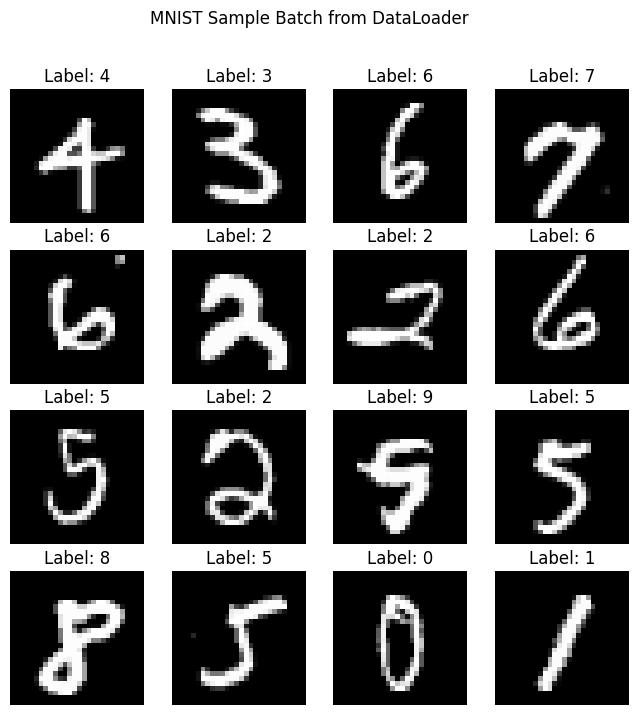

In [3]:
# 从 DataLoader 中取一个批次，观察数据形状和内容
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"一个批次的图像形状: {images.shape}") # [batch_size, channels, height, width] = [64, 1, 28, 28]
print(f"一个批次的标签形状: {labels.shape}") # [batch_size] = [64]

# 可视化批次中的前 16 个样本
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].squeeze(0) * 0.5 + 0.5  # 反归一化回 [0, 1]
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("MNIST Sample Batch from DataLoader")
plt.show()

In [4]:
# 定义一个简单的两层 MLP 模型
class SimpleMLP(nn.Module):
    """
    两层多层感知机（MLP）用于 MNIST 10 分类
    
    架构：
    - 输入层：28×28=784 维（图像展平）
    - 隐藏层：128 个神经元 + ReLU 激活
    - 输出层：10 个神经元（对应 10 个数字类别）
    """
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 第一层全连接层
        self.fc2 = nn.Linear(128, 10)       # 第二层全连接层（输出层）
        
    def forward(self, x):
        """
        前向传播
        
        Args:
            x: 输入张量，shape = [batch_size, 1, 28, 28]
            
        Returns:
            logits: 原始预测值（未经 softmax），shape = [batch_size, 10]
        """
        x = x.view(-1, 28 * 28)             # 展平为 [batch_size, 784]
        x = F.relu(self.fc1(x))             # 隐藏层 + ReLU 激活 -> [batch_size, 128]
        x = self.fc2(x)                     # 输出层 -> [batch_size, 10]
        return x

model = SimpleMLP()
print(model)

SimpleMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# 定义超参数
epochs = 50
lr = 0.01

# 定义优化器和损失函数
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # 结合 softmax 和交叉熵损失

print('开始训练...')
for epoch in range(epochs):
    model.train()  # 设置模型为训练模式
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):

        # 前向传播
        output = model(data)
        loss = criterion(output, target)

        # 反向传播与优化
        optimizer.zero_grad()  # 清除之前的梯度
        loss.backward()        # 计算梯度
        optimizer.step()       # 更新参数
        
        total_loss += loss.item()
    
    # 每 5 个 epoch 打印一次进度
    if (epoch + 1) % 5 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

print("训练完成！")

开始训练...
Epoch [5/50], Average Loss: 0.2756
Epoch [10/50], Average Loss: 0.1966
Epoch [15/50], Average Loss: 0.1499
Epoch [20/50], Average Loss: 0.1205
Epoch [25/50], Average Loss: 0.1003
Epoch [30/50], Average Loss: 0.0857
Epoch [35/50], Average Loss: 0.0745
Epoch [40/50], Average Loss: 0.0657
Epoch [45/50], Average Loss: 0.0585
Epoch [50/50], Average Loss: 0.0527
训练完成！


## 观察训练现象

通常在训练的中后期，会观察到**过拟合**现象：训练损失不断减小，但模型在测试集上的性能反而下降。后续我们会使用以下技巧来缓解过拟合：
- **Early Stopping**：当验证集性能不再改进时停止训练
- **学习率衰减**：逐步降低学习率以精细调整参数
- **正则化**：添加 Dropout、L2 正则等

详见 day4（CNN + Early Stopping）。

In [6]:
# 评估模型在测试集上的性能
model.eval()  # 设置模型为评估模式（关闭 Dropout 等）

with torch.no_grad():  # 不计算梯度，节省内存
    correct = 0
    total = 0
    
    for images, labels in test_loader:

        # 前向传播
        outputs = model(images)
        
        # 获取预测类别（logits 中的最大值对应的索引）
        _, predicted = torch.max(outputs.data, 1)

        # 统计正确预测数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'测试集上的准确率: {accuracy:.2f}%')

print("评估完成！")

测试集上的准确率: 97.46%
评估完成！


In [ ]:
# 可视化预测结果
images, labels = next(data_iter)

model.eval()
with torch.no_grad():
    logits = model(images)
    predicted = torch.argmax(logits, dim=1)

# 绘制前 16 个样本及其预测结果
plt.figure(figsize=(8, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].cpu().squeeze(0) * 0.5 + 0.5  # 反归一化
    plt.imshow(img.numpy(), cmap='gray')
    
    # 标题格式：真实标签 vs 预测标签
    label_text = f"GT: {labels[i].item()}\n PD: {predicted[i].item()}"
    # 正确预测用绿色，错误预测用红色
    color = 'green' if labels[i].item() == predicted[i].item() else 'red'
    plt.title(label_text, color=color, fontsize=10)
    plt.axis('off')

plt.suptitle("MNIST Classification", fontsize=12)
plt.tight_layout()
plt.show()